# 1.2 - IIR-Filterentwurf

<img style="float: right; margin:5px 0px 0px 10px" src="img/dsp.jpg" width="400">


## Inhalt  

<table style="width:256px; border: 1px solid black; display: inline-block">
  <tr>
    <td  style="text-align:right" width=64px><img src="img/IMG-intro.png" style="float:left"></td>
      <td style="text-align:left" width=256px>
          <a style="color:black; font-size:14px; font-weight:bold; text-decoration:none" href='#intro'>1. Wiederholung</a>
    </td>
  </tr>  
    <tr>
    <td  style="text-align:right" width=64px><img src="img/IMG-butterworth.png" style="float:left"></td>
      <td style="text-align:left" width=256px>
          <a style="color:black; font-size:14px; font-weight:bold; text-decoration:none" href='#idtft'>2. Butterworh-Filter</a>
    </td>
  </tr>  
    <tr>
    <td  style="text-align:right" width=64px><img src="img/IMG-chebyshev.png" style="float:left"></td>
      <td style="text-align:left" width=256px>
          <a style="color:black; font-size:14px; font-weight:bold; text-decoration:none" href='#idft'>3. Chebyshev-Filter</a>
    </td>
  </tr>
    <tr>
    <td  style="text-align:right" width=64px><img src="img/IMG-emphasis.jpg" style="float:left"></td>
      <td style="text-align:left" width=256px>
          <a style="color:black; font-size:14px; font-weight:bold; text-decoration:none" href='#verz'>4. ToDo: Vorverzerrung</a>
    </td>
  </tr>  
</table>

---

<a id='intro'></a><div><img src="img/IMG-intro.png" style="float:left"><h2 style="position: relative; top: 6px; left: 6px">1. Wiederholung </h2></div>

Im Notebook 1.1 haben wir die Implementierung von FIR-Filtern diskutiert. FIR-Filter bieten viele Vorteile wie einen linearen Phasengang, außerdem sind sie immer stabil. Zur Erinnerung: eine typische FIR hat die Differenzengleichung
\begin{equation*}
y_{\text{FIR}}(k) = \sum_{i=0}^{M}a_{i} x(k-i).
\end{equation*}  
Je länger der Filter/je höher die Filterordnung ($ M\rightarrow \infty $), desto besser kann der ideale Amplitudenfrequenzgang angenähert werden. Die z.T. hohe Anzahl an Koeffzienten kann ein Problem werden, wenn dadurch die Einschwingzeit des Filters zu lang ist. Eine Alternative bieten die IIR-Filter (Infinite Impulse Response Filter). Der größte Unterschied zwischen IIR- und FIR-Filtern besteht darin, dass die Ausgabe $y(k)$ zum aktuellen Abtastwertindex $k$ nicht nur von der Eingabe $x(k)$, sondern auch von vorherigen Abtastwerten der Ausgabe $y(k-1), y(k-2),\dots$ selbst abhängt. Die Standardform eines IIR-Filters lautet damit
\begin{equation*}
y_{\text{IIR}}(k) = \sum_{i=0}^{M} a_{i} x(k-i) - \underbrace{\sum_{i=0}^{N} b_{i} y(k-i)}_{\text{neuer, rekursiver Teil}}
\end{equation*}  

Die grundlegende Struktur von IIR-Filtern und dessen Darstellungsformen sind ebenfalls zur Erinnerung in der folgenden Abbildung noch einmal zusammengefasst (siehe dazu auch die Vorlesungsfolien Thema1-Filter sowie die erste Übung).

![iir](img/iir.png)

__Der Unterschied zwischen FIR- und IIR-Systemen:__  

- FIR:  
    - Impulsantwort hat eine endliche Länge
    - keine Rückkopplungsschleife/rekursiven Teil
    - keine Pole (immer stabil)
- IIR:  
    - Impulsantwort hat eine unendliche Länge
    - rekursive Struktur (Rückkopplungsschleife)
    - mindestens ein Pol ( $ b_{i} \neq  0 $ )

Im Allgemeinen wird beim Entwerfen eines digitalen IIR-Filters zuerst ein entsprechender analoger Filter entworfen und dann wird der analoge Filter durch eine [bilineare Transformation](https://en.wikipedia.org/wiki/Bilinear_transform) oder [Impulsantwort-Invarianzmethode](https://en.wikipedia.org/wiki/Impulse_invariance) in einen digitalen Filter umgewandelt. Dies bedeutet, dass die Systemfunktion $H(s)$ in der komplexen s-Ebene entworfen wird. Wenn sich alle Pole von $H(s)$ in der linken Halbebene von $s$ befinden, ist der Filter stabil. Die Komplexität liegt in der Bestimmung der Übertragungsfunktion des Analogfilters. 

Die einzelnen Implementierungsschritte umfassen dabei:
- Auswahl des Filtertyp, z.B. Butterworth oder Chebyshev 
- Wahl der Entwurfsparameter ($\omega_c$, Dämpfung, u.a.), 
- Pole mit den Gleichungen für $\phi_n$, $\gamma$ und $p_n$ bestimmen (siehe Vorlesung Thema1-Filter)

Nachfolgend soll der IIR-Filterentwurf für den Typ Butterworth und Chebychev durchgeführt und diskutiert werden. Die Gleichungen zur Bestimmung der Pole werden im Foliensatz zu Thema1-Filter erwähnt. In der Anwendung macht es mehr Sinn, die entsprechenden Funktionen aus dem Modul [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html) zu benutzen.

Importieren Sie zunächst alle für dieses Notebook nötigen externen Module:

In [1]:
# Lösung

# Importieren Sie aus dem scipy-Modul die Teilbibliothek "signal"
# Importieren Sie aus dem matplotlib-Modul die Teilbibliothek "pyplot" mit dem Alias "plt"
# Importieren Sie das numpy-Modul mit dem Alias "np"

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

<a id='butterworth'></a><div><img src="img/IMG-butterworth.png" style="float:left"><h2 style="position: relative; top: 6px; left: 6px">2. Butterworth-Filter </h2></div>

Butterworthfilter besitzen einen maximal steilen Übergang zwischen Durchlass- und Sperrbereich bei absolut glattem Amplitudengang im Duchlassbereich (kein Überschwingen). Ein analoger Butterworth-Filter besitzt keine Nullstellen (sog. "All-Pole-Filter"), bei der Transformation zum Digitalfilter kommen aber - abhängig von der Transformation (Bilinear, Pol-Nullstellen-Abbildung z.B.) -Nullstellen hinzu.

In diesem Abschnitt soll ein Bandpassfilter mittels [`signal.butter()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) entworfen. Die Abtastfrequenz $f_s$ beträgt 1000 Hz. Frequenzkomponenten unter 130 Hz und über 440 Hz sollen herausgefiltert werden, d.h., die Grenzfrequenzen $f_{c,\text{lower}}$ und $f_{c,\text{upper}}$ des Bandpassfilters betragen 130 Hz bis 440 Hz. Das Passbandintervall ist dann $f_{\text{pass}} = [130, 440]\,\mathrm{Hz}$. Die Einheit der Frequenzgrenzen in [`signal.butter()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) richten sich nach der Einheit der Abtastfrequenz, die als Argument übergeben wird. Oft werden sämtliche Frequenzen in $\Omega/\pi$ angegeben, wodurch die Frequenzachse von 0 Hz bis zur Nyquistfrequenz ($f_s/2$) auf den Bereich $[0, 1]$ normiert ist. z.T. es ist aber übersichtlicher, wenn die Frequenzachse weiterhin in Hz oder rad/s dargestellt ist. Unabhängig von der Wahl der Einheit für die Frequenzachse können die Filterpolynome jederzeit in eine andere Einheit skaliert werden, d.h. es ist nur wichtig, dass Abtast- und Grenzfrequenz(en) zusammenpassen. Gerade bei höheren Filterordnungen und hohen Abtastfrequenzwerten kann es zu numerischen Problem kommen, da die Polynomkoeffizienten schnell explodieren.

Zur graphischen Darstellung werden folgende Objekte verwendet: 
1. [`signal.freqz()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html) kann dann der Frequenzgang des Filters aus dem Zähler- und Nennerpolynom aus [`signal.butter()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) berechnet werden.
2. [`signal.tf2zpk`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.tf2zpk.html) rechnet das Zähler- und Nennerpolynom in Pol- und Nullstellen um.

In [2]:
'''
Beispiel: Butterworth Bandpassfilterentwurf mit verschiedenen Ordnungen
'''

for filterOrder in (2, 10, 20):  # Ordnung
    
    # Parameter
    fs_Hz = 1000                      # Abtastfrequenz
    fPass_Hz = [130/fs_Hz, 440/fs_Hz] # Grenzfrequenzen normalisiert
    

    # Filterentwurf
    a, b = signal.butter(filterOrder, fPass_Hz, 'Bandpass', analog=False, fs=fs_Hz/fs_Hz)  # Filterkoeffizienten
    f_Hz, H = signal.freqz(a, b, fs=fs_Hz)  # Frequenzgang des Filters
    z, p, k = signal.tf2zpk(a, b)        # Pol-Nullstellen-Verteilung


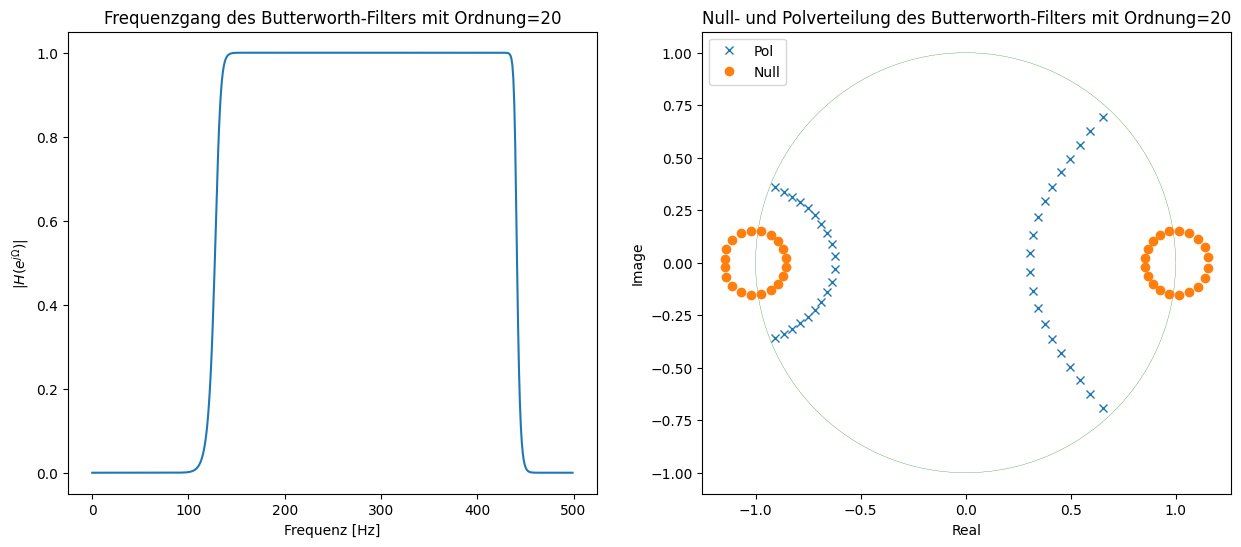

In [3]:
    # Graphische Darstellung
    plt.subplot(121)
    plt.title('Frequenzgang des Butterworth-Filters mit Ordnung=%d' %filterOrder)
    plt.xlabel('Frequenz [Hz]')
    plt.ylabel('$|H(e^{jΩ})|$')
    plt.plot(f_Hz, abs(H))

    
    plt.subplot(122)
    plt.title('Null- und Polverteilung des Butterworth-Filters mit Ordnung=%d' %filterOrder)
    plt.xlabel('Real')
    plt.ylabel('Image')
    theta = np.arange(0, 2*np.pi, 0.01)
    plt.plot(np.cos(theta), np.sin(theta), c='g', lw=0.2)  # Erzeugung des Einheitskreis
    plt.plot(np.real(p), np.imag(p), 'x', label=u"Pol")    # Polstellen
    plt.plot(np.real(z), np.imag(z), 'o', label=u"Null")   # Nullstellen
    plt.axis("equal")
    plt.legend(loc="upper left")                           # Erzeugung einer Legende
    plt.gcf().set_size_inches(15, 6)
    plt.show()

Zusätzlich gibt es die Funktion [signal.buttord()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html) zur Auswahl einer geeigneten Filterordnung in Abhängigkeit von festgelegten Randbedingungen bezüglich der Dämpfung im Durchlass- und Sperrbereich. Nachfolgend soll ein Bandpassfilter mittels dieser Funktion entworfen werden, damit die Dämpfung im Durchlassbereich innerhalb von 10 dB von 140 Hz bis 430 Hz liegt, während sie im Sperrbereich (außerhalb von $[130, 440]$ Hz) mindestens -40 dB beträgt.

In [4]:
'''
Beispiel: Butterworth Bandpassfilterentwurf mittels Ordnungselektion
'''

# Ordnungselektion
fs_Hz = 1000  # Abtastfrequenz
optOrder, WPass_rad = signal.buttord([140/fs_Hz, 430/fs_Hz], [130/fs_Hz, 440/fs_Hz], 10, 40, False, fs_Hz/fs_Hz)

# Filterentwurf
b, a = signal.butter(optOrder, WPass_rad, 'Bandpass', False, fs=fs_Hz/fs_Hz)  # Filterkoeffizienten
f_Hz, H = signal.freqz(b, a, fs=fs_Hz) # Frequenzgang des Filters
z, p, k = signal.tf2zpk(b, a)          # Null-Pol Verteilung


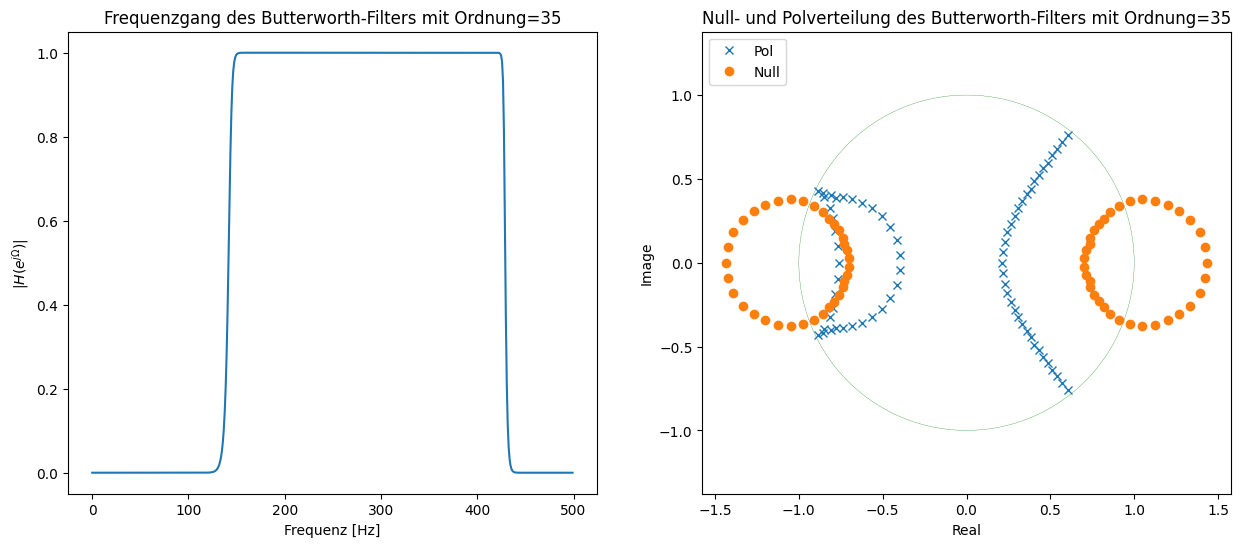

In [5]:
# Graphische Darstellung
plt.subplot(121)
plt.title('Frequenzgang des Butterworth-Filters mit Ordnung=%d' %optOrder)
plt.xlabel('Frequenz [Hz]')
plt.ylabel('$|H(e^{jΩ})|$')
plt.plot(f_Hz, abs(H))


plt.subplot(122)
plt.title('Null- und Polverteilung des Butterworth-Filters mit Ordnung=%d' %optOrder)
plt.xlabel('Real')
plt.ylabel('Image')
theta = np.arange(0, 2*np.pi, 0.01)
plt.plot(np.cos(theta), np.sin(theta), c='g', lw=0.2)  # Einheitskreis
plt.plot(np.real(p), np.imag(p), 'x', label=u"Pol")
plt.plot(np.real(z), np.imag(z), 'o', label=u"Null")
plt.axis("equal")
plt.legend(loc="upper left")
plt.gcf().set_size_inches(15, 6)
plt.show()

---

<a id='chebyshev'></a><div><img src="img/IMG-chebyshev.png" style="float:left"><h2 style="position: relative; top: 6px; left: 6px">3. Chebyshev-Filter </h2></div>

Beim Chebychev-Filter fällt die Amplitude im Übergangsbereich steiler ab als beim Butterworth-Filter. Dieser Vorteil wird durch eine gewisse
(einstellbare) Welligkeit im Durchlassbereich erkauft (unterhalb der Grenzfrequenz). 

Ähnlich wie Butterworth-Filterentwurf, gibt es auch für den Chebyshev-Filterentwurf Funktionen zur Ordnungselektion, daher können diese ganz analog dazu verwenden werden. Alle Details können Sie unter [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) finden.   

Außerdem gibt es eine allgemeine Funktion [signal.iirfilter()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) zum IIR-Filterentwurf, Im Nachfolgenden sollen diese Funktionen benutzt werden, um einen Chebyshev-Typ-I und -II Digitalfilter mit einer Abtastfrequenz von $f_s = 8000$ Hz zu entwerfen. Chebyshev Filter Typ I weisen eine Welligkeit im Passband auf, während Typ II Filter die Welligkeit im Stoppband haben.

- __Chebyshev Typ I__<br>
Entwerfen Sie eine for-Schleife zur Berechnung von Chebyshev-Hochpassfiltern des Typ I mit den unterschiedlichen Ordnung 2,5 und 10 (wie es für den Butterworth-Filter in Kapitel 2 schon umgesetzt wurde). Die Grenzfrequenz $f_c$ soll dabei 1500 Hz betragen und die Abtastfrequenz $f_s$ 8000 Hz. <br>
_Hinweis_: Der In- und Output der Objekte `signal.iirfilter()` und `signal.butter()` ähneln sich sehr. Zur Erzeugung des Chebyshev-HP-Filters benötigt es im Vergleich zu Kapitel 2 noch folgende Variableneinstellungen:  `(btype='highpass', ftype='cheby1', rp=1)`.

In [6]:
# Lösung
'''
Beispiel: Chebyshev Typ-I Hochpassfilterentwurf mit verschidenen Ordnungen
'''

for n in (2, 5, 10):  # Ordnung
    
    # Parameter
    fc_Hz = 1500 # Grenzfrequenz
    fs_Hz = 8000 # Abtastfrequenz

    # Filterentwurf
    a, b = signal.iirfilter(n, fc_Hz/fs_Hz, rp=1, btype='highpass', analog=False, ftype='cheby1', fs=fs_Hz/fs_Hz)
    f_Hz, H = signal.freqz(a, b, fs=fs_Hz) # Frequenzgang
    z, p, k = signal.tf2zpk(a, b)           # Null-Pol Verteilung


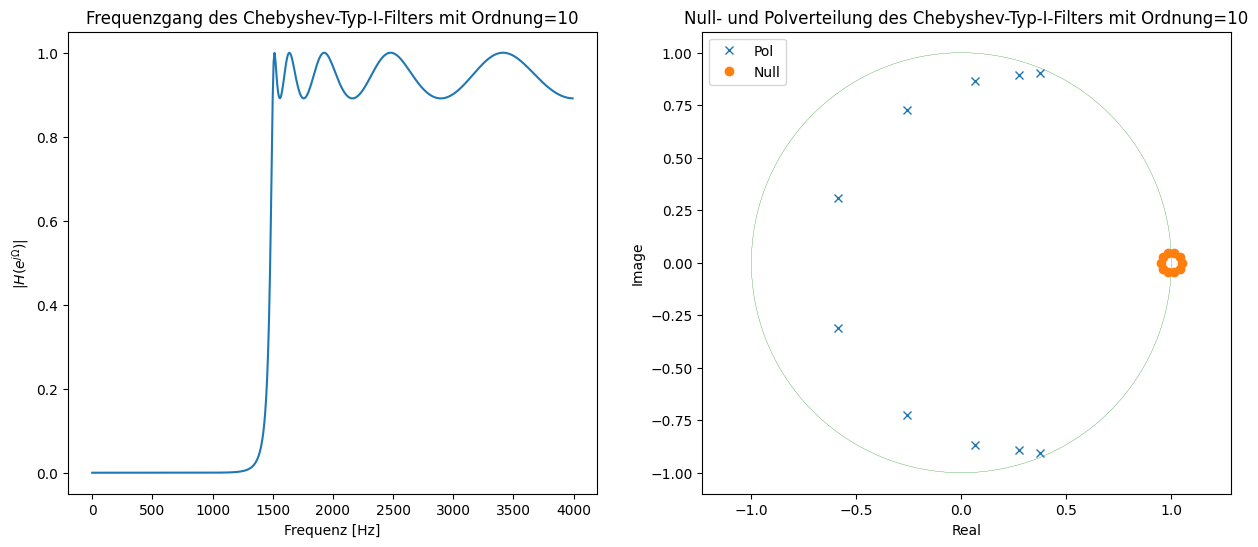

In [7]:
    # Plot
    plt.subplot(121)
    plt.plot(f_Hz, abs(H))
    plt.title('Frequenzgang des Chebyshev-Typ-I-Filters mit Ordnung=%d' %n)
    plt.xlabel('Frequenz [Hz]')
    plt.ylabel('$|H(e^{jΩ})|$')
    plt.subplot(122)
    plt.title('Null- und Polverteilung des Chebyshev-Typ-I-Filters mit Ordnung=%d' %n)
    plt.xlabel('Real')
    plt.ylabel('Image')
    theta = np.arange(0, 2*np.pi, 0.01)
    plt.plot(np.cos(theta), np.sin(theta), c='g', lw=0.2)  # Einheitskreis
    plt.plot(np.real(p), np.imag(p), 'x', label=u"Pol")
    plt.plot(np.real(z), np.imag(z), 'o', label=u"Null")
    plt.axis("equal")
    plt.legend(loc="upper left")
    plt.gcf().set_size_inches(15, 6)
    plt.show()

Nachfolgend soll ein Chebyshev-Bandstopp-Filter vom Typ 1 entworfen werden. Wie in Kapitel 2 soll auch hier Ordnungsselektion durchgeführt werden. Dies wird mit dem Objekt [`signal.cheb1ord()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cheb1ord.html) umgesetzt. Die Abtastfrequenz soll wieder bei $f_s = 8000$ Hz liegen, dessen Dämpfung im Sperrbereich von 1590 Hz bis 2990 Hz mindestens 40 dB beträgt, während die Dämpfung im Durchlassbereich (außerhalb von [1500,3000] Hz) innerhalb von -10 dB liegen soll.<br>
_Hinweis_: ändern Sie für  `signal.iirfilter()` die Variablen wie folgendermaßen:  `(btype='bandstop')`.


In [8]:
# Lösung

'''
Beispiel: Chebyshev Typ-I Bandsperrfilterentwurf mit Ordnungsselektion
'''
# Ordnungselektion
fs_Hz = 8000  # Abtastfrequenz
optOrder, WPass_rad = signal.cheb1ord([1500/fs_Hz, 3000/fs_Hz], [1590/fs_Hz, 2990/fs_Hz], 10, 40, False, fs_Hz/fs_Hz)

# Filterentwurf
a, b = signal.iirfilter(n, WPass_rad, rp=1, btype='bandstop', analog=False, ftype='cheby1', fs=fs_Hz/fs_Hz)
f_Hz, H = signal.freqz(a, b, fs=fs_Hz) # Frequenzgang
z, p, k = signal.tf2zpk(a, b)          # Null-Pol Verteilung


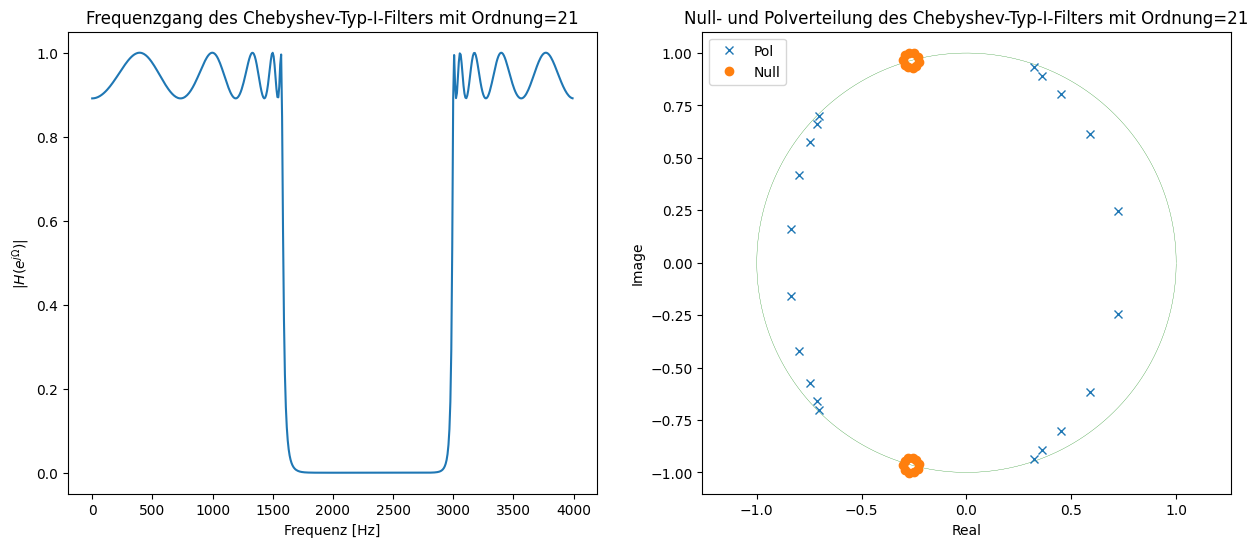

In [9]:
# Graphische Darstellung
plt.subplot(121)
plt.title('Frequenzgang des Chebyshev-Typ-I-Filters mit Ordnung=%d' %optOrder)
plt.xlabel('Frequenz [Hz]')
plt.ylabel('$|H(e^{jΩ})|$')
plt.plot(f_Hz, abs(H))

plt.subplot(122)
plt.title('Null- und Polverteilung des Chebyshev-Typ-I-Filters mit Ordnung=%d' %optOrder)
plt.xlabel('Real')
plt.ylabel('Image')
theta = np.arange(0, 2*np.pi, 0.01)
plt.plot(np.cos(theta), np.sin(theta), c='g', lw=0.2)  # Einheitskreis
plt.plot(np.real(p), np.imag(p), 'x', label=u"Pol")
plt.plot(np.real(z), np.imag(z), 'o', label=u"Null")
plt.axis("equal")
plt.legend(loc="upper left")
plt.gcf().set_size_inches(15, 6)
plt.show()

- __Chebyshev Typ II__<br>
Der Chebyshev-Filter des Typ 2 soll nun genutzt werden, um einen Tiefpass mit der Grenzfrequenz $f_c = 1500$ Hz bei einer Abtasfrequenz von $f_s = 8000$ Hz zu entwerfen. Es sollen analog zum vorherigen Chebyshev-Filter-Entwurf 1. Typs wieder Filter mit 2., 5. und 10. Ordnung ausgegeben werden.<br>
_Hinweis_: Ändern Sie für  `signal.iirfilter()` die Variablen folgendermaßen:  `(rs=20, btype='lowpass', analog=False, ftype='cheby2')`.

In [10]:
# Lösung

'''
Aufgabe: Chebyshev Typ-II Tiefpassilterentwurf mit verschidenen Ordnungen
'''

for filterOrder in (2, 5, 10):  # Ordnung
    
    # Parameter
    fc_Hz = 1500 # Grenzfrequenz
    fs_Hz = 8000 # Abtastfrequenz

    # Filterentwurf
    a, b = signal.iirfilter(filterOrder, fc_Hz/fs_Hz, rs=20, btype='lowpass', analog=False, ftype='cheby2', fs=fs_Hz/fs_Hz)
    w, H = signal.freqz(a, b, fs=fs_Hz) # Frequenzgang
    z, p, k = signal.tf2zpk(a, b)       # Null-Pol Verteilung


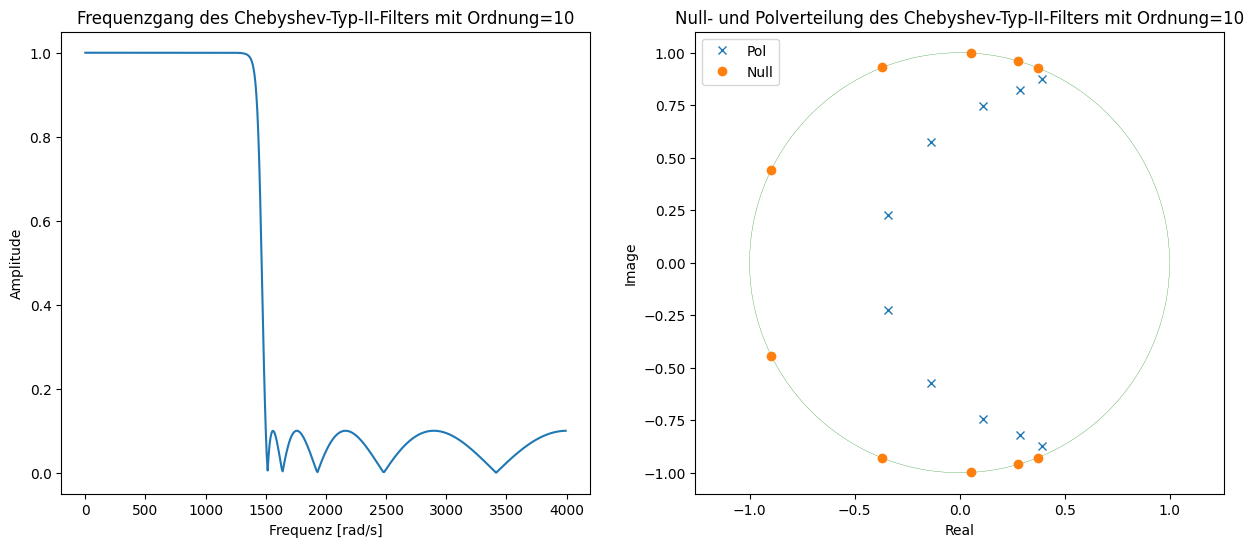

In [11]:
    # Plot
    plt.subplot(121)
    plt.title('Frequenzgang des Chebyshev-Typ-II-Filters mit Ordnung=%d' %filterOrder)
    plt.xlabel('Frequenz [rad/s]')
    plt.ylabel('Amplitude')
    plt.plot(w, abs(H))  

    plt.subplot(122)
    plt.title('Null- und Polverteilung des Chebyshev-Typ-II-Filters mit Ordnung=%d' %filterOrder)
    plt.xlabel('Real')
    plt.ylabel('Image')
    theta = np.arange(0, 2*np.pi, 0.01)
    plt.plot(np.cos(theta), np.sin(theta), c='g', lw=0.2)  # Einheitskreis
    plt.plot(np.real(p), np.imag(p), 'x', label=u"Pol")
    plt.plot(np.real(z), np.imag(z), 'o', label=u"Null")
    plt.axis("equal")
    plt.legend(loc="upper left")
    
    plt.gcf().set_size_inches(15, 6)
    plt.show()

Auch hier soll noch einmal die Ordnungsselektion für den Chebyshev-Filter vom Typ 2 verwendet werden. Dafür soll ein Chebyshev-Bandpass-Filter vom Typ 2 entworfen werden. Dies wird mit dem Objekt [`signal.cheb2ord()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cheb2ord.html) umgesetzt. Die Abtastfrequenz soll bei $f_s = 8000$ Hz liegen, dessen Dämpfung im Durchlassberech von 1590 Hz bis 2990 Hz  innerhalb von 10 dB, während sie im Sperrbereich (außerhalb von [1500,3000] Hz) mindestens -40 dB beträgt.<br>
_Hinweis_: ändern Sie für  `signal.iirfilter()` die Variablen wie folgendermaßen:  `(btype='bandpass')`.


In [12]:
# Lösung
'''
Aufgabe: Chebyshev Typ-II Bandpassfilterentwurf mit Ordnungselektion
'''

# Ordnungselektion
fs_Hz = 8000  # Abtastfrequenz
optOrder, wPass_rad = signal.cheb2ord([1590/fs_Hz, 2990/fs_Hz], [1500/fs_Hz, 3000/fs_Hz], 10, 40, False, fs_Hz/fs_Hz)

# Filterentwurf
a, b = signal.iirfilter(optOrder, wPass_rad, rs=20, btype='bandpass', analog=False, ftype='cheby2', fs=fs_Hz/fs_Hz)
f_Hz, H = signal.freqz(a, b, fs=fs_Hz) # Frequenzgang
z, p, k = signal.tf2zpk(a, b)          # Null-Pol Verteilung


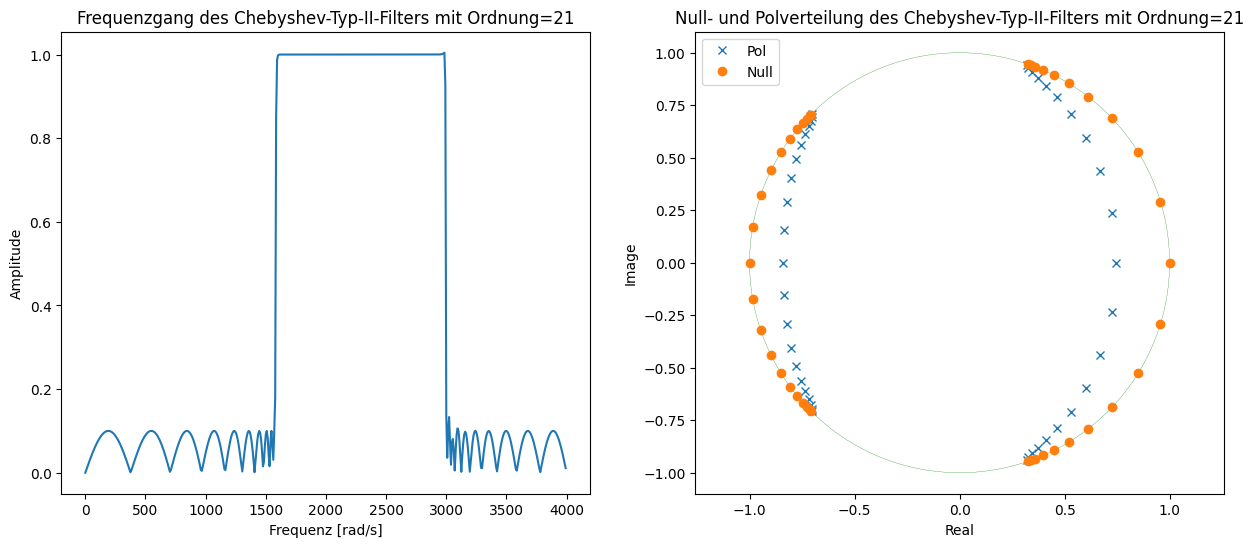

In [13]:
# Graphische Darstellung
plt.subplot(121)
plt.title('Frequenzgang des Chebyshev-Typ-II-Filters mit Ordnung=%d' %optOrder)
plt.xlabel('Frequenz [rad/s]')
plt.ylabel('Amplitude')
plt.plot(f_Hz, abs(H))

plt.subplot(122)
plt.title('Null- und Polverteilung des Chebyshev-Typ-II-Filters mit Ordnung=%d' %optOrder)
plt.xlabel('Real')
plt.ylabel('Image')
theta = np.arange(0, 2*np.pi, 0.01)
plt.plot(np.cos(theta), np.sin(theta), c='g', lw=0.2)  # Einheitskreis
plt.plot(np.real(p), np.imag(p), 'x', label=u"Pol")
plt.plot(np.real(z), np.imag(z), 'o', label=u"Null")
plt.axis("equal")
plt.legend(loc="upper left")
plt.gcf().set_size_inches(15, 6)
plt.show()

<a id='verz'></a><div><img src="img/IMG-emphasis.jpg" style="float:left"><h2 style="position: relative; top: 6px; left: 6px">4. Vorverzerrung </h2></div>

Wenn ein analoger Filter $H_{lp}$ mit einer festgelegten Grenzfrequenz mittels der Bilineartransformation in einen digitalen Filter $Hd_{lp}$ überführt werden soll, wird diese durch die Achsenverzerrung von der s- in die z-Ebene verzerrt und die Grenzfrequenz des Digitalfilters ist u.U. deutlich daneben (die Verzerrung wird stärker für höhere Grenzfrequenzen). Aus diesem Grund wird die analoge Grenzfrequenz zunächst _vorverzerrt_, danach die Filterkoeffizienten berechnet und anschließend der analoge Filter in einen digitalen Filter transformiert. Für die Transformation in den z-Bereich kann die [signal.cont2discrete()]() Funktion verwendet werden. 

Im Nachfolgenden wird zunächst ein analoger Butterworth-Filter 3. Ordnung erstellt mit der bereits kennengelernten Funktion [signal.butter()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html), wobei die analog=True flag gesetzt werden muss. Zum Plotten des analogen Frequenzganges eignen sich die [signal.TransferFunction()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.TransferFunction.html) und [signal.bode()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bode.html) Funktionen.

Für die Vorverzerrung wird die neue Grenzfrequenz $\omega_c^{\prime}$ über den in der Vorlesung kennengelernten Ausdruck
\begin{equation}
\omega_c^{\prime} = 2f_s\cdot \tan\left(\frac{\omega_c}{2\cdot f_s}\right)
\end{equation}
berechnet. 

In [14]:
'''
Beispiel für das Vorverzerren und der anschließenden Transformation vom Analog- zum Digitalfilter
'''

fs_Hz = 2000               # Samplingfrequenz
ws_rad_s = 2*np.pi*fs_Hz   # Samplingfrequenz
dt = 1/fs_Hz               # Abtastintervall
fc_Hz = 500                # Grenzfrequenz des Filters
wc_rad_s = fc_Hz*2*np.pi   # Grenzfrequenz des Filters
Wc_rad = wc_rad_s/fs_Hz    # Normalisierte Grenzfrequenz 
# Inline function für Umrechnung der vorverzerrten Frequenz VOR der Transformation:
analogFreqPreWarping = lambda wc_rad_s, fs_Hz: 2*fs_Hz*np.tan(wc_rad_s/(fs_Hz*2)) 

# Grenzfrequenz vorverzerren:
wcPw_rad_s = analogFreqPreWarping(wc_rad_s, fs_Hz)
print("{} {} {}".format("Vorverzerrte Grenzfrequenz: ", wcPw_rad_s, "rad/s"))

# Koeffizienten eines Butterworth-Filters berechnen:
filterOrder = 3
a, b = signal.butter(filterOrder, wcPw_rad_s, 'lowpass', analog=True)  # Filterkoeffizienten des analogen Tiefpasses
Hlp = signal.TransferFunction(a, b) # Systemfunktion des Analogfilters

# Analog zu diskret Transformation des Tiefpasses:
ad, bd, dt = signal.cont2discrete((a, b), 1/fs_Hz, 'bilinear')
ad = ad.flatten() # sonst spinnen die Dimensionen von ad...


Vorverzerrte Grenzfrequenz:  3999.9999999999995 rad/s


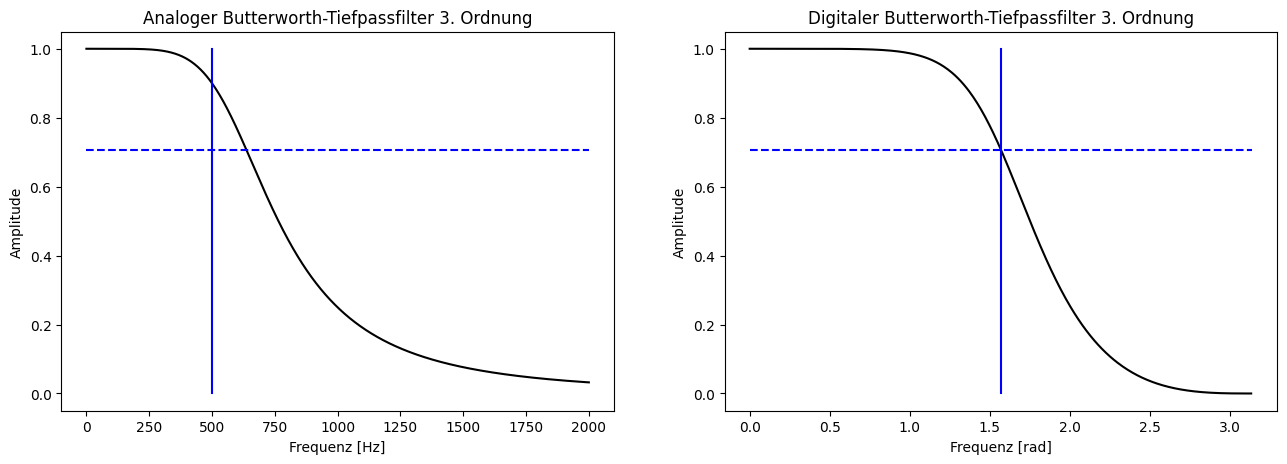

In [15]:
# Plotten der Frequenzgänge:
wPlot_rad_s = np.arange(0, fs_Hz*2*np.pi, 1) # Frequenzachse zum Plotten
w, mag, phase = Hlp.bode(w=wPlot_rad_s)      # Frequenzgang des Analogfilters
wd, Hdlp = signal.freqz(ad, bd, fs=fs_Hz)    # Frequenzgang des Digitalfilters

plt.subplot(121)
plt.plot(wPlot_rad_s/(2*np.pi), 10**(mag/20), '-k')
plt.plot([wc_rad_s/(2*np.pi), wc_rad_s/(2*np.pi)], [0, 1],'-b')
plt.plot([0, ws_rad_s/(2*np.pi)], [1/np.sqrt(2), 1/np.sqrt(2)],'--b')
plt.title('Analoger Butterworth-Tiefpassfilter %d. Ordnung' %filterOrder)
plt.xlabel('Frequenz [Hz]')
plt.ylabel('Amplitude')
plt.subplot(122)
plt.plot(wd/fs_Hz*2*np.pi, abs(Hdlp),'-k')
plt.plot([Wc_rad, Wc_rad], [0, 1],'-b')
plt.plot([0, np.pi], [1/np.sqrt(2), 1/np.sqrt(2)],'--b')
plt.title('Digitaler Butterworth-Tiefpassfilter %d. Ordnung' %filterOrder)
plt.xlabel('Frequenz [rad]')
plt.ylabel('Amplitude')
plt.subplots_adjust(left=0.1, right=2, top=0.9)

Im ersten Fall (unverzerrt) sollte der Amplitudenfrequenzgang des Analogfilters bei der Grenzfrequenz $w_c$ $1/\sqrt(2)$ betragen, die äquivalente Grenzfrequenz des Digitalfilters aber kleiner als gewollt sein. Wenn der Digitalfilter dagegen mit der vorverzerrten Grenzfrequenz $w_{c,pw}$ berechnet wird, ist die Grenzfrequenz des Analogfilters höher als gewollt (was in diesem Falle egal ist, da ja der Digitalfilter interessiert), die des Digitalfilters passt aber genau.

---

### References

1. Titelbild von [Avon Ampo](https://www.eeweb.com/audio-signal-processing/)  
2. DSP Guide: [The Scientist and Engineer's Guide to
Digital Signal Processing](http://www.dspguide.com/pdfbook.htm)
3. Python-Modul von Signalverarbeitung: [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html)
---
<div>Notebook erstellt von Arne-Lukas Fietkau, Yifei Li  und <a href="mailto:christoph.wagner@tu-dresden.de?Subject=Frage%20zu%20Jupyter%20Notebook%201.2%20IIR%20Filterentwurf" target="_top">Christoph Wagner</a></div>